In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import time
import queue

In [3]:
path = 'data/musae_facebook_22000.csv'
G = nx.read_edgelist(path, delimiter=',', nodetype=int)
A = nx.linalg.graphmatrix.adjacency_matrix(G)
print(nx.info(G))

node_target = 109

# plot matrix
#plt.spy(A,marker=',')
#plt.show()

Name: 
Type: Graph
Number of nodes: 22470
Number of edges: 171002
Average degree:  15.2205


Elapsed time:  0.173902 seconds


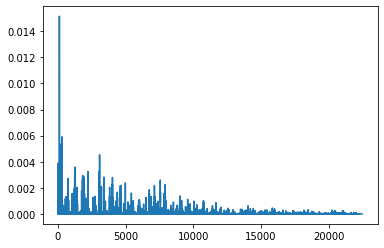

In [31]:
#compute PageRank algorith with power iteration (from network science)
def pageRank(M, t, iterations):
    N = M.shape[1]
    c = 0.85
    p = np.ones(N)/N

    for i in range(iterations):
        p = c * M * p + (1-c) * t #pagerank formula
        p = p/sum(p) #normalization

    return p


# dimension of the matrix
N = A.shape[0]

# for normal pagerank all nodes have the same teleport probability
# t = np.ones(N)/N 

# for local pagerank only a subset of nodes have non-negative probabilty
t = np.zeros(N)
t[node_target] = 9

start = time.time()
p = pageRank(A, t, 40)
stop = time.time()
print('Elapsed time: ', str(stop-start)[0:8], 'seconds')
plt.plot(p)
plt.show()

In [11]:
def approximatePageRank(G, target_nodes, alpha, epsilon):

    #pagerank
    p = {}

    #residuals
    r = target_nodes

    #degrees
    d = {}
    for n in target_nodes:
        d[n] = G.out_degree(n)

    queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key])]

    while(queue):

        # take the first element of the queue
        node_u = queue[0]
        
        # push operation
        if node_u in p:
            p[node_u] += alpha * r[node_u]
        else:
            p[node_u] = alpha * r[node_u]
        
        r[node_u] = (1-alpha) * r[node_u] / 2

        for node_v in G.neighbors(node_u):
            if node_v in r:
                r[node_v] += r[node_u] / d[node_u]
            else:
                r[node_v] = r[node_u] / d[node_u]
                d[node_v] = G.out_degree(n)

        # recompute the queue
        queue = [key for key in r.keys() if (d[key] > 0) and (r[key] >= epsilon * d[key])]
        
    
    # get values and keys from p dictionary
    p_values = list(p.values())
    p_keys = np.array(list(p.keys()))

    # normalize pageRank vector
    p_values = np.array(p_values) / sum(p_values)

    return p_keys, p_values

Elapsed time: 0.656140 seconds


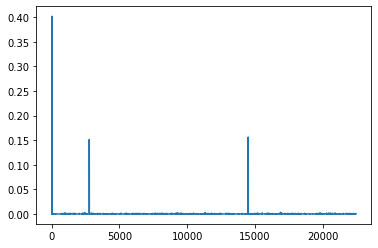

In [29]:
personalization_vector = {9:1}
alpha = 0.15
epsilon = 1e-5

start = time.time()
k, p = approximatePageRank(G, personalization_vector, alpha, epsilon)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')

pp = np.zeros(np.max(k)+1)
pp[k] = p
    
#sort_index = np.argsort(k)
#k = k[sort_index]
#p = p[sort_index]
#print(k[np.argmax(p)])  #dovrebbe venire il nodo target
#max_pos = np.argmax(p)
#p[max_pos] = 0
#plt.plot(k, p)
plt.plot(pp)
plt.show()

Elapsed time: 7.075269 seconds


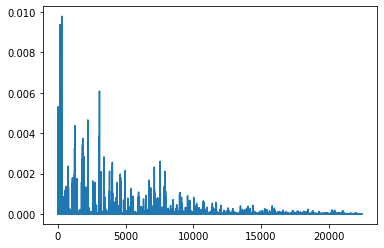

In [30]:
#alpha = 0.8
#epsilon = 1e-2

start = time.time()
p = nx.pagerank(G, personalization=personalization_vector, max_iter=40, weight=None)
#p = nx.pagerank(G, personalization=residuals, max_iter=40, weight=None, tol=epsilon, alpha=alpha)
stop = time.time()
print('Elapsed time:', str(stop-start)[0:8], 'seconds')
p = list(p.values())
plt.plot(p)
plt.show()

TASK 2: speed up using Basis Vector as in http://infolab.stanford.edu/~glenj/spws.pdf

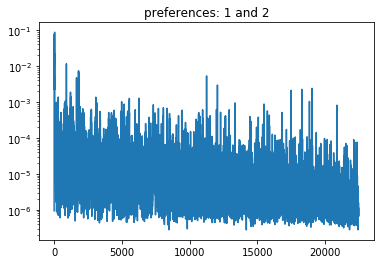

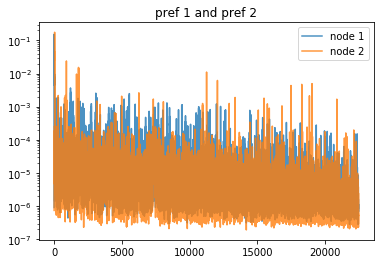

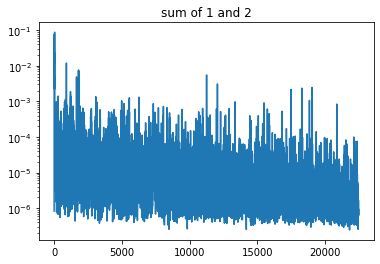

In [36]:
p = nx.pagerank(G, personalization={1:1,2:1}, max_iter=40, weight=None)
p = list(p.values())
plt.plot(p)
plt.title("preferences: 1 and 2")
plt.yscale("log")
plt.show()

p1 = nx.pagerank(G, personalization={1:1}, max_iter=40, weight=None)
p1 = list(p1.values())
plt.plot(p1, alpha=0.8, label="node 1")
plt.title("pref 1 and pref 2")
plt.yscale("log")

p2 = nx.pagerank(G, personalization={2:1}, max_iter=40, weight=None)
p2 = list(p2.values())
plt.plot(p2, alpha=0.8, label="node 2")
plt.legend()
plt.show()

p3 = (np.array(p1)+np.array(p2))/2
plt.plot(p3)
plt.title("sum of 1 and 2")
plt.yscale("log")
plt.show()